# TabM精简版：性早熟预测模型

**使用精简特征集（9个特征）进行模型训练**

精简特征基于医生临床经验筛选：
- LH/FSH 相关：基础LH、基础FSH、LH/FSH比值
- 骨龄相关：骨龄、骨龄与实际年龄比值、生物年龄和骨龄之间的差异
- 子宫卵巢径线/体积：子宫长宽厚体积、左右卵巢长宽厚体积、卵巢平均值

本笔记本流程与 Tabm_Enhanced.ipynb 一致

## 1. 导入必要的库

In [1]:
import os
import math
import random
from copy import deepcopy

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import tabm
import rtdl_num_embeddings
import torch
import torch.nn as nn
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print(f"TabM版本: {tabm.__version__ if hasattr(tabm, '__version__') else 'N/A'}")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
print("所有库导入完成")

TabM版本: 0.0.3
PyTorch版本: 2.9.1+cu130
CUDA可用: True
GPU设备: NVIDIA GeForce RTX 3080 Laptop GPU
所有库导入完成


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/tabm_simplified", exist_ok=True)
os.makedirs("./output/tabm_simplified/models", exist_ok=True)

RANDOM_SEED = 825
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"随机种子设置: {RANDOM_SEED}")
print(f"计算设备: {DEVICE}")
print(f"输出目录: ./output/tabm_simplified/")

随机种子设置: 825
计算设备: cuda
输出目录: ./output/tabm_simplified/


## 3. 读取精简特征数据

In [3]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, {normal_data.shape[1]} 列")
print(f"早熟组: {disease_data.shape[0]} 行, {disease_data.shape[1]} 列")
print(f"\n精简特征列表:")
for col in normal_data.columns:
    if col not in ["group", "患者编号"]:
        print(f"  - {col}")

正常组: 299 行, 13 列
早熟组: 364 行, 13 列

精简特征列表:
  - 基础血清促黄体生成激素（LH）
  - 基础血清卵泡刺激素（FSH）
  - 骨龄(岁)
  - 骨龄与实际年龄比值
  - 子宫长（cm）
  - 子宫厚（cm）
  - 最大卵泡直径直径
  - 左卵巢体积（长X宽X厚X0.5233）
  - 右卵巢体积（长X宽X厚X0.5233）
  - 卵巢体积平均值
  - LH/FSH比值


## 4. 数据合并与划分

In [4]:
# 分组填补：先对每组分别填补，再合并
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

print(f"使用 {len(feature_cols)} 个精简特征")
print("使用MissForest方法进行分组填补...")

# 分别对正常组和性早熟组进行填补
imputer_normal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
imputer_disease = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

normal_features = normal_data[feature_cols].copy()
disease_features = disease_data[feature_cols].copy()

normal_imputed = pd.DataFrame(
    imputer_normal.fit_transform(normal_features), columns=feature_cols
)
disease_imputed = pd.DataFrame(
    imputer_disease.fit_transform(disease_features), columns=feature_cols
)

print(f"正常组填补完成: {normal_imputed.shape}")
print(f"性早熟组填补完成: {disease_imputed.shape}")

# 添加标签列
normal_imputed["group"] = "N"
disease_imputed["group"] = "Y"

# 合并数据
data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

# 划分训练集和验证集
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)
print(f"\n训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

使用 11 个精简特征
使用MissForest方法进行分组填补...
正常组填补完成: (299, 11)
性早熟组填补完成: (364, 11)

合并后数据: 663 行 x 12 列
分组统计:
group
Y    364
N    299
Name: count, dtype: int64

训练集: 464 行, 验证集: 199 行


## 5. 特征工程与预处理

In [5]:
X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

# 数据已在分组填补阶段完成，直接使用
X_train_num = X_train.values
X_validation_num = X_validation.values

# 标准化
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_num)
X_validation_processed = scaler.transform(X_validation_num)
print("数值特征已标准化")

feature_cols_processed = feature_cols
print(f"\n预处理完成！特征数: {X_train_processed.shape[1]}")

训练集正负样本: {1: 255, 0: 209}
验证集正负样本: {1: 109, 0: 90}
数值特征已标准化

预处理完成！特征数: 11


## 6. 数据转换为PyTorch张量

In [6]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).to(DEVICE)
X_val_tensor = torch.tensor(X_validation_processed, dtype=torch.float32).to(DEVICE)
y_val_tensor = torch.tensor(y_validation_binary.values, dtype=torch.long).to(DEVICE)

print(f"训练集张量: {X_train_tensor.shape}")
print(f"验证集张量: {X_val_tensor.shape}")

训练集张量: torch.Size([464, 11])
验证集张量: torch.Size([199, 11])


## 7. 定义训练和评估函数

In [7]:
def train_tabm_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    n_epochs=500,
    batch_size=256,
    lr=2e-3,
    weight_decay=3e-4,
    patience=32,
    gradient_clipping_norm=1.0,
    share_training_batches=True,
    verbose=True,
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    amp_enabled = torch.cuda.is_available()

    best_f1, best_auc, best_epoch, best_state = 0, 0, 0, None
    remaining_patience = patience

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        if share_training_batches:
            batches = torch.randperm(len(X_train), device=DEVICE).split(batch_size)
        else:
            batches = (
                torch.rand((len(X_train), model.backbone.k), device=DEVICE)
                .argsort(dim=0)
                .split(batch_size, dim=0)
            )

        for batch_idx in batches:
            optimizer.zero_grad()
            with torch.autocast(
                device_type="cuda", enabled=amp_enabled, dtype=amp_dtype
            ):
                logits = model(X_train[batch_idx], None)
                y_pred = logits.flatten(0, 1)
                if share_training_batches:
                    y_true = y_train[batch_idx].repeat_interleave(model.backbone.k)
                else:
                    y_true = y_train[batch_idx].flatten(0, 1)
                loss = nn.functional.cross_entropy(y_pred, y_true)
            loss.backward()
            if gradient_clipping_norm:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), gradient_clipping_norm
                )
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val, None)
            val_proba = (
                torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
            )
            val_pred = (val_proba >= 0.5).astype(int)
            y_val_np = y_val.cpu().numpy()
            auc = roc_auc_score(y_val_np, val_proba)
            f1 = f1_score(y_val_np, val_pred)

        improved = f1 > best_f1
        if verbose and (epoch % 50 == 0 or improved):
            print(
                f"Epoch {epoch:3d}: Loss={total_loss/len(batches):.4f}, F1={f1:.4f}, AUC={auc:.4f}{' *' if improved else ''}"
            )
        if improved:
            best_f1, best_auc, best_epoch = f1, auc, epoch
            best_state = deepcopy(model.state_dict())
            remaining_patience = patience
        else:
            remaining_patience -= 1
        if remaining_patience < 0:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    if best_state:
        model.load_state_dict(best_state)
    return {"best_f1": best_f1, "best_auc": best_auc, "best_epoch": best_epoch}


def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        pred = (proba >= 0.5).astype(int)
        y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else y
        return {
            "auc": roc_auc_score(y_np, proba),
            "f1": f1_score(y_np, pred),
            "accuracy": accuracy_score(y_np, pred),
            "y_pred": pred,
            "y_proba": proba,
        }


print("训练和评估函数定义完成！")

训练和评估函数定义完成！


## 8. 模型1：基础TabM

In [8]:
print("=" * 70)
print("训练基础TabM模型（精简特征）")
print("=" * 70)

num_embeddings_basic = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_basic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_basic,
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_basic.parameters()):,}")
print(f"特征数: {X_train_tensor.shape[1]}")

result_basic = train_tabm_model(
    tabm_basic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=500,
)
metrics_basic = evaluate_model(tabm_basic, X_val_tensor, y_val_tensor)

print(
    f"\n基础TabM性能: AUC={metrics_basic['auc']:.4f}, F1={metrics_basic['f1']:.4f}, ACC={metrics_basic['accuracy']:.4f}"
)
torch.save(tabm_basic.state_dict(), "./output/tabm_simplified/models/tabm_basic.pt")
joblib.dump(
    {
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "./output/tabm_simplified/models/tabm_basic_preprocessors.pkl",
)
# 基础TabM性能: AUC=0.8657, F1=0.9103, ACC=0.8571 5

训练基础TabM模型（精简特征）
模型参数量: 481,440
特征数: 11
Epoch   0: Loss=0.6826, F1=0.7500, AUC=0.8193 *
Epoch   1: Loss=0.6317, F1=0.7769, AUC=0.8260 *
Epoch   2: Loss=0.5583, F1=0.8000, AUC=0.8464 *
Epoch   3: Loss=0.4768, F1=0.8093, AUC=0.8667 *
Epoch   4: Loss=0.4367, F1=0.8416, AUC=0.8802 *
Epoch   5: Loss=0.4020, F1=0.8611, AUC=0.8928 *
Epoch   7: Loss=0.3683, F1=0.8646, AUC=0.8980 *
Epoch   9: Loss=0.3153, F1=0.8899, AUC=0.9066 *
Epoch  10: Loss=0.3003, F1=0.8908, AUC=0.9086 *
Epoch  16: Loss=0.2323, F1=0.8996, AUC=0.9264 *
Epoch  18: Loss=0.2171, F1=0.9043, AUC=0.9297 *
Epoch  25: Loss=0.1725, F1=0.9075, AUC=0.9401 *
Epoch  32: Loss=0.1405, F1=0.9083, AUC=0.9478 *
Epoch  50: Loss=0.0652, F1=0.8987, AUC=0.9511
Epoch 100: Loss=0.0060, F1=0.8860, AUC=0.9506
Epoch 150: Loss=0.0017, F1=0.8821, AUC=0.9525
Epoch 200: Loss=0.0011, F1=0.8821, AUC=0.9491
Epoch 250: Loss=0.0005, F1=0.8783, AUC=0.9502
Epoch 300: Loss=0.0004, F1=0.8821, AUC=0.9513
Epoch 350: Loss=0.0003, F1=0.8793, AUC=0.9499
Epoch 400: Los

['./output/tabm_simplified/models/tabm_basic_preprocessors.pkl']

## 9. 模型2：TabM-Mini架构

In [9]:
print("=" * 70)
print("训练TabM-Mini架构（精简特征）")
print("=" * 70)

num_embeddings_mini = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_mini = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_mini,
    arch_type="tabm-mini",
).to(DEVICE)

result_mini = train_tabm_model(
    tabm_mini,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=500,
)
metrics_mini = evaluate_model(tabm_mini, X_val_tensor, y_val_tensor)

print(
    f"\nTabM-Mini性能: AUC={metrics_mini['auc']:.4f}, F1={metrics_mini['f1']:.4f}, ACC={metrics_mini['accuracy']:.4f}"
)
torch.save(tabm_mini.state_dict(), "./output/tabm_simplified/models/tabm_mini.pt")

训练TabM-Mini架构（精简特征）
Epoch   0: Loss=0.6827, F1=0.7200, AUC=0.8596 *
Epoch   1: Loss=0.6332, F1=0.7726, AUC=0.8675 *
Epoch   2: Loss=0.5553, F1=0.8584, AUC=0.8798 *
Epoch   3: Loss=0.4640, F1=0.8622, AUC=0.8863 *
Epoch   4: Loss=0.4064, F1=0.8673, AUC=0.8922 *
Epoch   6: Loss=0.3706, F1=0.8722, AUC=0.9001 *
Epoch   7: Loss=0.3347, F1=0.8745, AUC=0.9040 *
Epoch  10: Loss=0.2849, F1=0.8870, AUC=0.9097 *
Epoch  16: Loss=0.2184, F1=0.8918, AUC=0.9305 *
Epoch  17: Loss=0.2166, F1=0.8957, AUC=0.9329 *
Epoch  18: Loss=0.2078, F1=0.8996, AUC=0.9350 *
Epoch  20: Loss=0.1910, F1=0.9043, AUC=0.9377 *
Epoch  21: Loss=0.1897, F1=0.9083, AUC=0.9386 *
Epoch  50: Loss=0.0687, F1=0.8987, AUC=0.9476
Epoch 100: Loss=0.0071, F1=0.8899, AUC=0.9503
Epoch 150: Loss=0.0016, F1=0.8860, AUC=0.9521
Epoch 200: Loss=0.0007, F1=0.8860, AUC=0.9509
Epoch 250: Loss=0.0004, F1=0.8860, AUC=0.9545
Epoch 300: Loss=0.0003, F1=0.8860, AUC=0.9462
Epoch 350: Loss=0.0003, F1=0.8860, AUC=0.9512
Epoch 400: Loss=0.0001, F1=0.8860,

## 10. 模型3：独立批次训练

In [10]:
print("=" * 70)
print("训练TabM（独立批次策略）")
print("=" * 70)

num_embeddings_indep = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_indep = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_indep,
).to(DEVICE)

result_indep = train_tabm_model(
    tabm_indep,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=500,
    share_training_batches=False,
)
metrics_indep = evaluate_model(tabm_indep, X_val_tensor, y_val_tensor)

print(
    f"\nTabM独立批次性能: AUC={metrics_indep['auc']:.4f}, F1={metrics_indep['f1']:.4f}, ACC={metrics_indep['accuracy']:.4f}"
)
torch.save(tabm_indep.state_dict(), "./output/tabm_simplified/models/tabm_indep.pt")

训练TabM（独立批次策略）
Epoch   0: Loss=0.6820, F1=0.7105, AUC=0.8331 *
Epoch   1: Loss=0.6294, F1=0.7518, AUC=0.8483 *
Epoch   2: Loss=0.5559, F1=0.8416, AUC=0.8687 *
Epoch   4: Loss=0.4242, F1=0.8636, AUC=0.8876 *
Epoch   7: Loss=0.3440, F1=0.8722, AUC=0.9055 *
Epoch   8: Loss=0.3210, F1=0.8811, AUC=0.9086 *
Epoch   9: Loss=0.3041, F1=0.8908, AUC=0.9100 *
Epoch  15: Loss=0.2327, F1=0.8918, AUC=0.9311 *
Epoch  16: Loss=0.2234, F1=0.8957, AUC=0.9318 *
Epoch  19: Loss=0.1986, F1=0.9004, AUC=0.9397 *
Epoch  20: Loss=0.1928, F1=0.9083, AUC=0.9396 *
Epoch  50: Loss=0.0380, F1=0.8850, AUC=0.9523
Epoch 100: Loss=0.0020, F1=0.8821, AUC=0.9494
Epoch 150: Loss=0.0006, F1=0.8860, AUC=0.9485
Epoch 200: Loss=0.0004, F1=0.8821, AUC=0.9479
Epoch 250: Loss=0.0004, F1=0.8821, AUC=0.9479
Epoch 300: Loss=0.0003, F1=0.8889, AUC=0.9495
Epoch 350: Loss=0.0001, F1=0.8850, AUC=0.9460
Epoch 400: Loss=0.0001, F1=0.8860, AUC=0.9460
Epoch 450: Loss=0.0001, F1=0.8860, AUC=0.9472

TabM独立批次性能: AUC=0.9396, F1=0.9083, ACC=0.8

## 11. 模型4：PeriodicEmbeddings

In [11]:
print("=" * 70)
print("训练TabM（PeriodicEmbeddings）")
print("=" * 70)

num_embeddings_periodic = rtdl_num_embeddings.PeriodicEmbeddings(
    n_features=X_train_tensor.shape[1],
    d_embedding=16,
    lite=False,
)
tabm_periodic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_periodic,
).to(DEVICE)

result_periodic = train_tabm_model(
    tabm_periodic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=500,
)
metrics_periodic = evaluate_model(tabm_periodic, X_val_tensor, y_val_tensor)

print(
    f"\nTabM-Periodic性能: AUC={metrics_periodic['auc']:.4f}, F1={metrics_periodic['f1']:.4f}, ACC={metrics_periodic['accuracy']:.4f}"
)
torch.save(
    tabm_periodic.state_dict(), "./output/tabm_simplified/models/tabm_periodic.pt"
)

训练TabM（PeriodicEmbeddings）
Epoch   0: Loss=0.6881, F1=0.7078, AUC=0.8420 *
Epoch   4: Loss=0.6252, F1=0.8254, AUC=0.8634 *
Epoch   5: Loss=0.5791, F1=0.8621, AUC=0.8714 *
Epoch  11: Loss=0.3645, F1=0.8673, AUC=0.8909 *
Epoch  17: Loss=0.2957, F1=0.8761, AUC=0.9011 *
Epoch  21: Loss=0.2586, F1=0.8783, AUC=0.9083 *
Epoch  22: Loss=0.2509, F1=0.8821, AUC=0.9115 *
Epoch  26: Loss=0.2272, F1=0.8899, AUC=0.9216 *
Epoch  29: Loss=0.1990, F1=0.8978, AUC=0.9283 *
Epoch  50: Loss=0.1192, F1=0.8919, AUC=0.9390
Epoch 100: Loss=0.0332, F1=0.8829, AUC=0.9462
Epoch 111: Loss=0.0243, F1=0.8987, AUC=0.9429 *
Epoch 150: Loss=0.0090, F1=0.8929, AUC=0.9486
Epoch 200: Loss=0.0051, F1=0.8929, AUC=0.9439
Epoch 250: Loss=0.0023, F1=0.8938, AUC=0.9469
Epoch 284: Loss=0.0033, F1=0.9027, AUC=0.9419 *
Epoch 290: Loss=0.0036, F1=0.9067, AUC=0.9419 *
Epoch 300: Loss=0.0023, F1=0.8978, AUC=0.9436
Epoch 350: Loss=0.0011, F1=0.9027, AUC=0.9404
Epoch 400: Loss=0.0019, F1=0.8889, AUC=0.9366
Epoch 450: Loss=0.0037, F1=0.

## 12. 模型5：超参数优化（Optuna HPO）

In [12]:
print("=" * 70)
print("TabM超参数优化（Optuna）")
print("=" * 70)

best_hpo_model_state = None
best_hpo_f1 = 0.0
best_hpo_config = None


def objective(trial):
    global best_hpo_model_state, best_hpo_f1, best_hpo_config
    n_blocks = trial.suggest_int("n_blocks", 1, 4)
    d_block = trial.suggest_int("d_block", 64, 512, step=64)
    n_bins = trial.suggest_int("n_bins", 16, 96, step=16)
    d_embedding = trial.suggest_int("d_embedding", 8, 32, step=4)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.05)
    try:
        num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
            rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
            d_embedding=d_embedding,
            activation=False,
            version="B",
        )
        model = tabm.TabM.make(
            n_num_features=X_train_tensor.shape[1],
            cat_cardinalities=[],
            d_out=2,
            num_embeddings=num_embeddings,
            n_blocks=n_blocks,
            d_block=d_block,
            dropout=dropout,
        ).to(DEVICE)
        result = train_tabm_model(
            model,
            X_train_tensor,
            y_train_tensor,
            X_val_tensor,
            y_val_tensor,
            n_epochs=800,
            patience=250,
            lr=lr,
            weight_decay=weight_decay,
            verbose=False,
        )
        f1 = result["best_f1"]
        if f1 > best_hpo_f1:
            best_hpo_f1 = f1
            best_hpo_model_state = deepcopy(model.state_dict())
            best_hpo_config = {
                "n_blocks": n_blocks,
                "d_block": d_block,
                "n_bins": n_bins,
                "d_embedding": d_embedding,
                "dropout": dropout,
            }
        return f1
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


study = optuna.create_study(direction="maximize", study_name="tabm_simplified_hpo")
study.optimize(objective, n_trials=5000, show_progress_bar=True)

print(f"\n最佳参数: {study.best_params}")
print(f"最佳F1: {study.best_value:.4f}")

torch.save(best_hpo_model_state, "./output/tabm_simplified/models/tabm_hpo.pt")
joblib.dump(
    {
        "best_params": study.best_params,
        "best_config": best_hpo_config,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "./output/tabm_simplified/models/tabm_hpo_config.pkl",
)

[I 2025-12-24 14:36:47,973] A new study created in memory with name: tabm_simplified_hpo


TabM超参数优化（Optuna）


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2025-12-24 14:36:52,627] Trial 0 finished with value: 0.9004329004329005 and parameters: {'n_blocks': 4, 'd_block': 128, 'n_bins': 32, 'd_embedding': 32, 'lr': 0.0007893007825290108, 'weight_decay': 0.017762060523876227, 'dropout': 0.2}. Best is trial 0 with value: 0.9004329004329005.
[I 2025-12-24 14:36:58,142] Trial 1 finished with value: 0.9082969432314411 and parameters: {'n_blocks': 1, 'd_block': 128, 'n_bins': 48, 'd_embedding': 16, 'lr': 0.00021099382886641819, 'weight_decay': 0.006054847366319229, 'dropout': 0.15000000000000002}. Best is trial 1 with value: 0.9082969432314411.
[I 2025-12-24 14:37:02,672] Trial 2 finished with value: 0.9043478260869565 and parameters: {'n_blocks': 2, 'd_block': 448, 'n_bins': 48, 'd_embedding': 24, 'lr': 0.000311532298260122, 'weight_decay': 0.0015870097267595789, 'dropout': 0.3}. Best is trial 1 with value: 0.9082969432314411.
[I 2025-12-24 14:37:05,389] Trial 3 finished with value: 0.9074889867841409 and parameters: {'n_blocks': 1, 'd_block

['./output/tabm_simplified/models/tabm_hpo_config.pkl']

## 13. 评估HPO最佳模型

In [13]:
num_embeddings_hpo = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=best_hpo_config["n_bins"]),
    d_embedding=best_hpo_config["d_embedding"],
    activation=False,
    version="B",
)
tabm_hpo = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_hpo,
    n_blocks=best_hpo_config["n_blocks"],
    d_block=best_hpo_config["d_block"],
    dropout=best_hpo_config["dropout"],
).to(DEVICE)
tabm_hpo.load_state_dict(best_hpo_model_state)
metrics_hpo = evaluate_model(tabm_hpo, X_val_tensor, y_val_tensor)
print(
    f"HPO优化TabM性能: AUC={metrics_hpo['auc']:.4f}, F1={metrics_hpo['f1']:.4f}, ACC={metrics_hpo['accuracy']:.4f}"
)

HPO优化TabM性能: AUC=0.9517, F1=0.9381, ACC=0.9296


## 14. 性能对比与可视化

In [14]:
results = pd.DataFrame(
    {
        "模型": [
            "基础TabM",
            "TabM-Mini",
            "TabM独立批次",
            "TabM-Periodic",
            "HPO优化TabM",
        ],
        "AUC": [
            metrics_basic["auc"],
            metrics_mini["auc"],
            metrics_indep["auc"],
            metrics_periodic["auc"],
            metrics_hpo["auc"],
        ],
        "F1": [
            metrics_basic["f1"],
            metrics_mini["f1"],
            metrics_indep["f1"],
            metrics_periodic["f1"],
            metrics_hpo["f1"],
        ],
        "ACC": [
            metrics_basic["accuracy"],
            metrics_mini["accuracy"],
            metrics_indep["accuracy"],
            metrics_periodic["accuracy"],
            metrics_hpo["accuracy"],
        ],
    }
)
print("TabM精简特征模型性能对比")
print(results.to_string(index=False))
results.to_csv("./output/tabm_simplified/性能对比.csv", index=False)
# TabM精简特征模型性能对比（dropna）
#            模型      AUC       F1      ACC
#        基础TabM 0.811505 0.817204 0.762349
#     TabM-Mini 0.819570 0.817691 0.763747
#      TabM独立批次 0.811737 0.813319 0.754427
# TabM-Periodic 0.794619 0.803395 0.740913
#     HPO优化TabM 0.819428 0.822430 0.769804

TabM精简特征模型性能对比
           模型      AUC       F1      ACC
       基础TabM 0.947808 0.908297 0.894472
    TabM-Mini 0.938634 0.908297 0.894472
     TabM独立批次 0.939551 0.908297 0.894472
TabM-Periodic 0.941896 0.906667 0.894472
    HPO优化TabM 0.951682 0.938053 0.929648


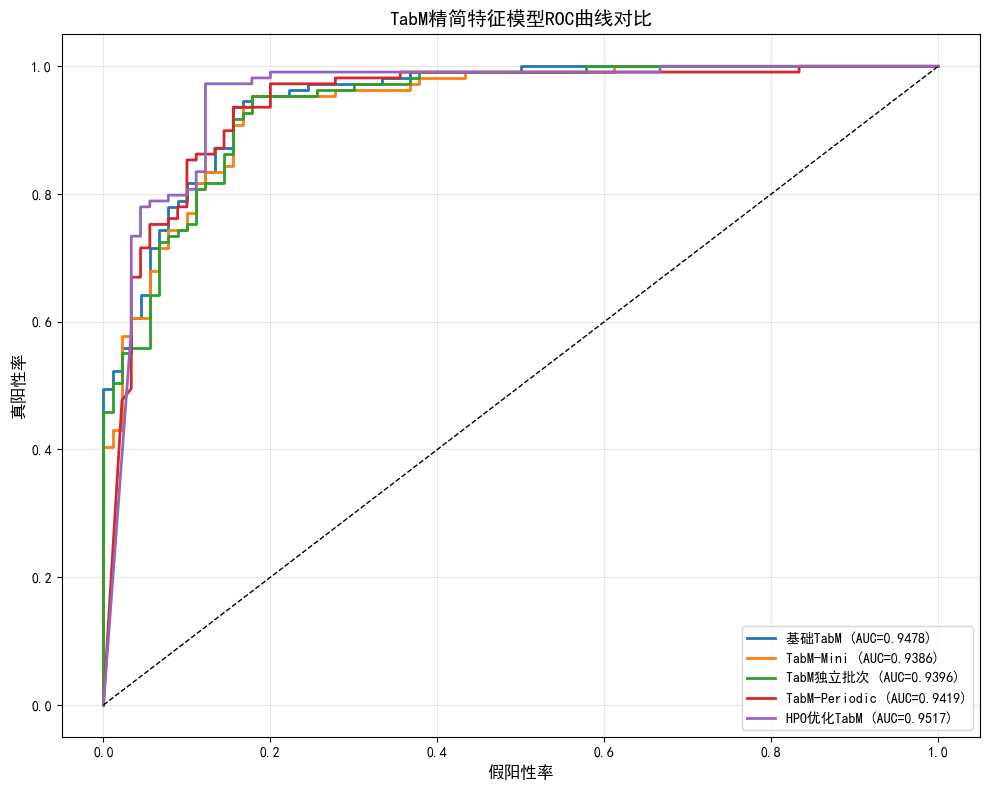

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
models_data = [
    ("基础TabM", metrics_basic),
    ("TabM-Mini", metrics_mini),
    ("TabM独立批次", metrics_indep),
    ("TabM-Periodic", metrics_periodic),
    ("HPO优化TabM", metrics_hpo),
]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
for (name, m), color in zip(models_data, colors):
    fpr, tpr, _ = roc_curve(y_validation_binary, m["y_proba"])
    ax.plot(fpr, tpr, label=f"{name} (AUC={m['auc']:.4f})", color=color, linewidth=2)
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_xlabel("假阳性率", fontsize=12)
ax.set_ylabel("真阳性率", fontsize=12)
ax.set_title("TabM精简特征模型ROC曲线对比", fontsize=14)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./output/tabm_simplified/ROC曲线对比.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
def calc_metrics(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "F1": f1_score(y_true, y_pred),
        "ACC": accuracy_score(y_true, y_pred),
        "敏感性": sens,
        "特异性": spec,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }


y_val_np = y_validation_binary.values
detailed = []
for name, m in models_data:
    d = calc_metrics(y_val_np, m["y_pred"], m["y_proba"])
    d["模型"] = name
    detailed.append(d)
detailed_df = pd.DataFrame(detailed)
print(detailed_df.to_string(index=False))
detailed_df.to_csv("./output/tabm_simplified/详细性能指标.csv", index=False)

     AUC       F1      ACC      敏感性      特异性  TP  TN  FP  FN            模型
0.947808 0.908297 0.894472 0.954128 0.822222 104  74  16   5        基础TabM
0.938634 0.908297 0.894472 0.954128 0.822222 104  74  16   5     TabM-Mini
0.939551 0.908297 0.894472 0.954128 0.822222 104  74  16   5      TabM独立批次
0.941896 0.906667 0.894472 0.935780 0.844444 102  76  14   7 TabM-Periodic
0.951682 0.938053 0.929648 0.972477 0.877778 106  79  11   3     HPO优化TabM


In [17]:
val_results = validation_data.copy()
val_results["真实标签"] = y_validation_binary.values
val_results["HPO_预测"] = metrics_hpo["y_pred"]
val_results["HPO_概率"] = metrics_hpo["y_proba"]
val_results.to_csv("./output/tabm_simplified/验证集预测结果.csv", index=False)
print(f"验证集预测结果已保存，共 {len(val_results)} 条记录")

验证集预测结果已保存，共 199 条记录


In [ ]:
print("=" * 70)
print("TabM精简特征模型训练完成")
print("=" * 70)
print(f"使用特征数: {len(feature_cols_processed)} (vs 全特征38个)")
print(f"\n最佳模型: {results.loc[results['F1'].idxmax(), '模型']}")
print(f"  F1: {results['F1'].max():.4f}")

TabM精简特征模型训练完成
使用特征数: 11 (vs 全特征38个)

最佳模型: HPO优化TabM
  F1: 0.9381


: 